# Evaluación Final Módulo 3

In [115]:
# IMPORTAMOS LAS LIBRERÍAS QUE NECESITAMOS

# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Imputación de nulos
# -----------------------------------------------------------------------
from sklearn.impute import SimpleImputer 
from sklearn.experimental import enable_iterative_imputer # Necesario para IterativeImputer
from sklearn.impute import IterativeImputer 
from sklearn.impute import KNNImputer 

# Visualización
# -----------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluar linealidad de las relaciones entre las variables
# y la distribución de las variables
# ------------------------------------------------------------------------
import scipy.stats as st
import scipy.stats as stats
from scipy.stats import shapiro, poisson, chisquare, expon, kstest

# Configuración
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames

In [116]:
# FUNCIONES: 

# Visualización rápida de los datos: 
# -----------------------------------------------------------------------
def visualizacion_datos(dataframe): 
    print('VISUALIZACIÓN RÁPIDA DE LOS DATOS:')
    print('--' * 17)
    display(dataframe.head(3))
    display(dataframe.tail(3))
    display(dataframe.sample(3))
    print('--' * 120)
    print(f'El número de filas es de {dataframe.shape[0]} y el número de columnas es de {dataframe.shape[1]}.')
    print('Las diferentes columnas que tenemos son:')
    num = 0
    for i in dataframe.columns: 
        num +=1
        print(f'    {num}. {i}')
    print('--' * 120)
    print('INFORMACIÓN DEL CONJUNTO DE DATOS:')
    print('--' * 17)
    dataframe.info()

# Duplicados:
# ----------------------------------------------------------------------- 
def func_duplicados(dataframe): 
    if dataframe.duplicated().sum() > 0:
        print(f'El número de filas es de {dataframe.shape[0]}')
        print(f'El número de duplicados es: {dataframe.duplicated().sum()}.')
        print('Borrando duplicados...')
        dataframe.drop_duplicates(inplace = True)
        print(f'Se han eliminado los duplicados.')
        print(f'Comprobando que el número de duplicados sea cero.')
        print(f'Comprobación: {dataframe.duplicated().sum()}')
        print(f'Ahora el número de filas es: {dataframe.shape[0]}')
    else: 
        print('Este dataframe no tiene duplicados.')

# Valores nulos
# -----------------------------------------------------------------------------------------------
# Con esta función podemos saber que variables de nuestro dataframe y en que porcentaje 
# tienen valores nulos. 
# Nos devuleve el nombre de las columnas que tiene dichos valores nulos, de manera que podemos 
# guardarlas en una variable (lista), por si se necesitan a posteriori.
# ----------------------------------------------------------------------------------------------- 
def variables_nulas(dataframe): 
    nulos = (dataframe.isnull().sum()/dataframe.shape[0]*100).reset_index()
    nulos.rename(columns={'index': 'columna', 0:'%_nulos'}, inplace=True)
    mascara = nulos['%_nulos'] > 0

    if nulos['%_nulos'].sum() == 0: 
        print('Ninguna columna tiene valores nulos. Puedes continuar con tu estudio.')
    else: 
        col_nulos = nulos.loc[nulos['%_nulos']!=0, 'columna'].to_list() 
        display(nulos[mascara])
        for i in col_nulos:
            print(f'La siguiente columna tiene valores nulos: {i}')
        return col_nulos
    

# Creación de boxplots: 
# -----------------------------------------------------------------------------------------------
## FUNCIÓN PARA CREAR BOXPLOTS EN ANÁLISIS DE VARIABLES NUMÉRICAS: 
# Esta función hay que indicarle dos cosas: la primera es el dataframe y el segundo son las 
# columnas del dataframe que queremos hacer los boxplots.
# Devuelve la representación del boxplot, la media y la mediana.  
# IMPORTANTE: Las columnas se tienen que dar en una lista y las calumnas deben de ser numéricas. 
# -----------------------------------------------------------------------------------------------

def avn_boxplot(dataframe, columna): 
    for var in columna:
        sns.boxplot(data=dataframe, x=var)
        mean_var = round(dataframe[var].mean(), 2)
        median_var = round(dataframe[var].median(), 2)
        plt.axvline(x=mean_var, color = 'red', linestyle = '--', linewidth = 2, label = f'Media: {mean_var}')
        plt.axvline(x=median_var, color = 'green', linestyle = '--', linewidth = 2, label = f'Mediana: {median_var}')
        plt.legend()
        plt.show();

### FASE 1: Exploración y limpieza.

1. **Exploración inicial:**

    - Realiza una exploración inicial de los datos para identificar posibles problemas, como valores nulos, atípicos o datos faltantes en las columnas relevantes.
    - Utiliza funciones de Pandas para obtener información sobre la estructura de los datos, la presencia de valores nulos y estadísticas básicas de las columnas involucradas.
    - Une los dos conjuntos de datos de la forma más eficiente.



2. **Limpieza de datos:**

    - Elimina o trata los valores nulos, si los hay, en las columnas clave para asegurar que los datos estén completos.
    - Verifica la consistencia y corrección de los datos para asegurarte de que los datos se presenten de forma coherente.
    - Realiza cualquier ajuste o conversión necesaria en las columnas (por ejemplo, cambiar tipos de datos) para garantizar la adecuación de los datos para el análisis estadístico.

In [117]:
## Cargamos los datos de ambos ficheros: 

df_CFA = pd.read_csv('data/Customer-Flight-Activity.csv')
df_CLH = pd.read_csv('data/Customer-Loyalty-History.csv')

En primer lugar se estudiará el conjunto de datos "Customer Fligth Analysis" y posteriormente, se hará lo mismo con el conjunto de datos "Customer Loyalty History".

## **Dataframe**: Customer Fligth Analysis 

Este archivo contiene información sobre la actividad de vuelo de los clientes, incluyendo el número de vuelos reservados, la distancia volada, puntos acumulados y redimidos, y costos asociados a los puntos redimidos. 

- **Loyalty Number**: Este atributo representa un identificador único para cada cliente dentro del programa de lealtad de la aerolínea. Cada número de lealtad corresponde a un cliente específico.
- **Year**: Indica el año en el cual se registraron las actividades de vuelo para el cliente.
- **Month**: Representa el mes del año (de 1 a 12) en el cual ocurrieron las actividades de vuelo.
- **Flights Booked**: Número total de vuelos reservados por el cliente en ese mes específico.
- **Flights with Companions**: Número de vuelos reservados en los cuales el cliente viajó con acompañantes.
- **Total Flights**: El número total de vuelos que el cliente ha realizado, que puede incluir vuelos reservados en meses anteriores.
- **Distance**: La distancia total (presumiblemente en millas o kilómetros) que el cliente ha volado durante el mes.
- **Points Accumulated**: Puntos acumulados por el cliente en el programa de lealtad durante el mes, con base en la distancia volada u otros factores.
- **Points Redeemed**: Puntos que el cliente ha redimido en el mes, posiblemente para obtener beneficios como vuelos gratis, mejoras, etc.
- **Dollar Cost Points Redeemed**: El valor en dólares de los puntos que el cliente ha redimido durante el mes.

In [118]:
visualizacion_datos(df_CFA)

VISUALIZACIÓN RÁPIDA DE LOS DATOS:
----------------------------------


,Loyalty Number,Year,Month,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed
0,100018,2017,1,3,0,3,1521,152.0,0,0
1,100102,2017,1,10,4,14,2030,203.0,0,0
2,100140,2017,1,6,0,6,1200,120.0,0,0


,Loyalty Number,Year,Month,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed
405621,999940,2018,12,3,0,3,1233,123.0,0,0
405622,999982,2018,12,0,0,0,0,0.0,0,0
405623,999986,2018,12,0,0,0,0,0.0,0,0


,Loyalty Number,Year,Month,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed
64657,840659,2017,4,0,0,0,0,0.0,0,0
261052,501217,2018,4,0,0,0,0,0.0,0,0
341378,963410,2018,11,4,4,8,992,99.0,421,34


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
El número de filas es de 405624 y el número de columnas es de 10.
Las diferentes columnas que tenemos son:
    1. Loyalty Number
    2. Year
    3. Month
    4. Flights Booked
    5. Flights with Companions
    6. Total Flights
    7. Distance
    8. Points Accumulated
    9. Points Redeemed
    10. Dollar Cost Points Redeemed
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
INFORMACIÓN DEL CONJUNTO DE DATOS:
----------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405624 entries, 0 to 405623
Data columns (total 10 columns):
 #   Col

In [119]:
# Ninguna variable tiene valores nulos. 

In [120]:
# Vamos a homogeneizar los nombres de las columnas, siendo el cambio que le vamos a hacer quitar los espacios en los nombres y sustituirlos por 
# barras bajas (_); ya que tener espacios en los nombres de nuestras columnas pueden llevar a errores cuando queramos realizar algunos comandos. 

new_col = {col: col.replace(' ', '_') for col in df_CFA.columns}
df_CFA.rename(columns=new_col, inplace=True)
df_CFA.columns

Index(['Loyalty_Number', 'Year', 'Month', 'Flights_Booked',
       'Flights_with_Companions', 'Total_Flights', 'Distance',
       'Points_Accumulated', 'Points_Redeemed', 'Dollar_Cost_Points_Redeemed'],
      dtype='object')

In [121]:
# Vamos a realizar un análisis descriptivo de los datos para poder tener una idea general de los mismos. 
df_CFA.describe().T

,count,mean,std,min,25%,50%,75%,max
Loyalty_Number,405624.0,550037.873084,258935.286969,100018.0,326961.00,550834.0,772194.00,999986.0
Year,405624.0,2017.500000,0.500001,2017.0,2017.00,2017.5,2018.00,2018.0
Month,405624.0,6.500000,3.452057,1.0,3.75,6.5,9.25,12.0
Flights_Booked,405624.0,4.115052,5.225518,0.0,0.00,1.0,8.00,21.0
Flights_with_Companions,405624.0,1.031805,2.076869,0.0,0.00,0.0,1.00,11.0
Total_Flights,405624.0,5.146858,6.521227,0.0,0.00,1.0,10.00,32.0
Distance,405624.0,1208.880059,1433.155320,0.0,0.00,488.0,2336.00,6293.0
Points_Accumulated,405624.0,123.692721,146.599831,0.0,0.00,50.0,239.00,676.5
Points_Redeemed,405624.0,30.696872,125.486049,0.0,0.00,0.0,0.00,876.0
Dollar_Cost_Points_Redeemed,405624.0,2.484503,10.150038,0.0,0.00,0.0,0.00,71.0


In [122]:
# En nuestro conjunto de datos no existe ninguna variable que sea de tipo categórica, por lo que no tenemos que hacer un 
# análisis estadístico a parte de este tipo de variables.

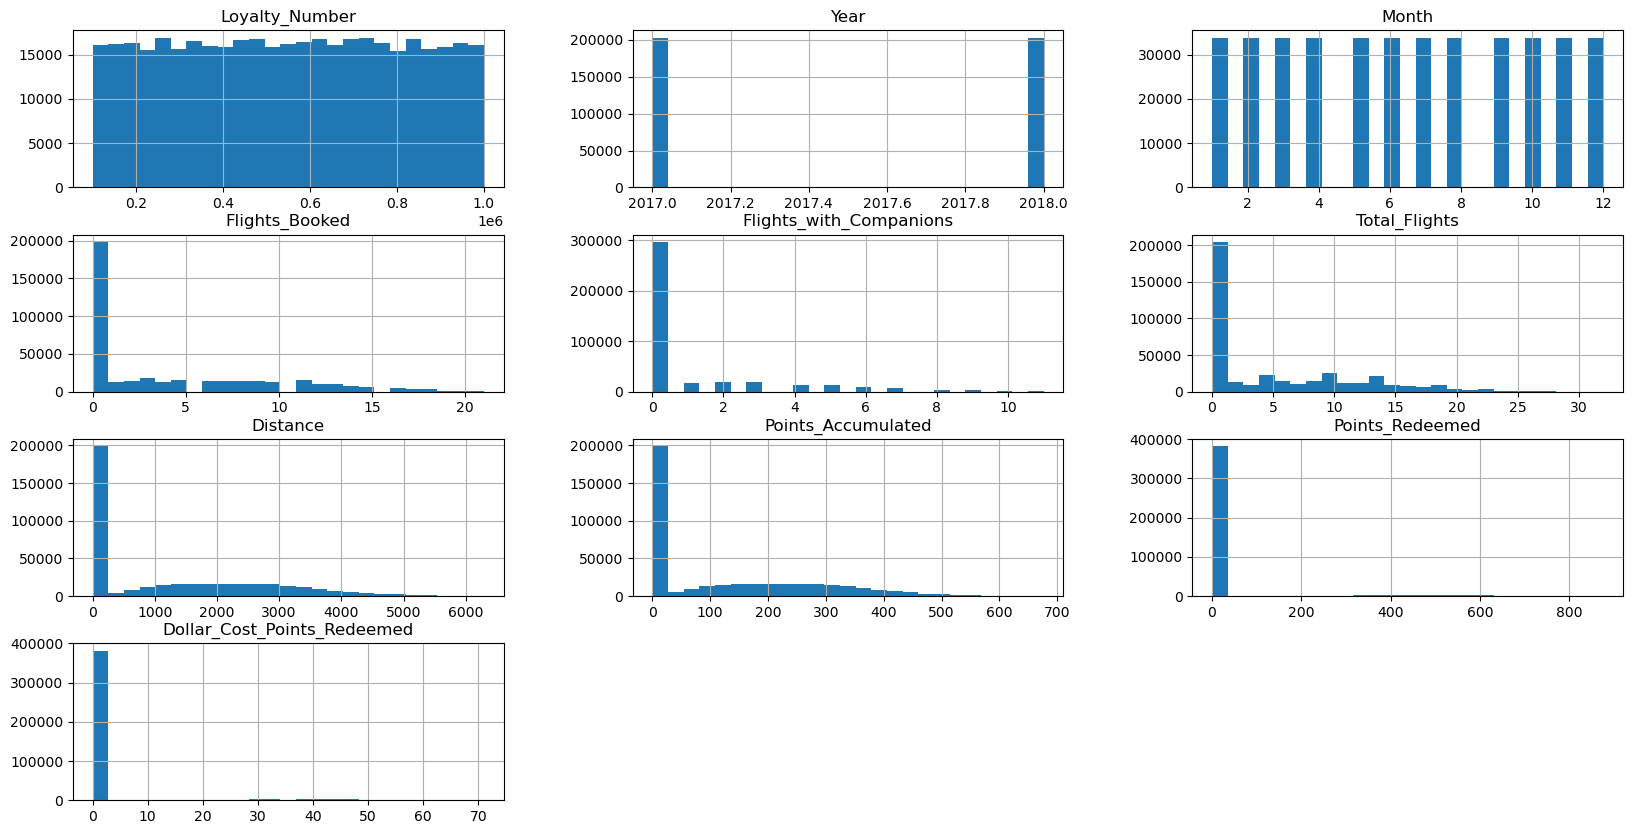

In [123]:
# Vamos a hacer un análisis de las variables. 

# Histograma: 

df_CFA.hist(bins=25, figsize=(20, 10));

In [124]:
# Aunque realizamos los histogramas de todas las columnas, no tendría mucho sentido hacerlas, ya que algunas variables como puede ser "Loyalty Number" no 
# niene sentido representarla porque es un identificador único de cliente o "Flights Booked", ya que son el total de vuelos reservados por el cliente en 
# un mes específico y sin tener en cuenta el mes, no tiene sentido su representación. 

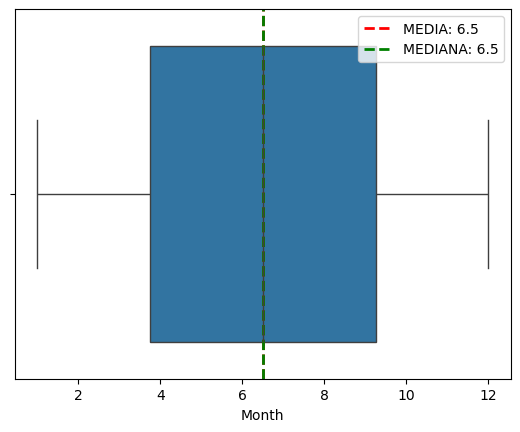

In [125]:
# Vamos a hacer unos boxplots de aquellas variables que parezca tener más sentido representar.

sns.boxplot(data = df_CFA, x = 'Month')
mean_month = df_CFA['Month'].mean()
median_month = df_CFA['Month'].median()
plt.axvline(x = mean_month, color = 'red', linestyle='--', linewidth = 2, label = f"MEDIA: {mean_month}")
plt.axvline(x = median_month, color = 'green', linestyle='--', linewidth = 2, label = f"MEDIANA: {median_month}")
plt.legend();


In [126]:
# Realizar un boxplots con la variable 'Month', no nos arroja grandes conclusiones, ya que para todos los meses tenemos el mismo número de datos.
df_CFA['Month'].value_counts()

Month
1     33802
9     33802
2     33802
3     33802
11    33802
4     33802
5     33802
7     33802
6     33802
8     33802
10    33802
12    33802
Name: count, dtype: int64

In [127]:
# DUPLICADOS: 
# Con esta función vamos a ver si tenemos duplicados y en el caso de tenerlos los va a eliminar. 
func_duplicados(df_CFA)

El número de filas es de 405624
El número de duplicados es: 1864.
Borrando duplicados...
Se han eliminado los duplicados.
Comprobando que el número de duplicados sea cero.
Comprobación: 0
Ahora el número de filas es: 403760


In [128]:
# NULOS: 
nulos_CFA = variables_nulas(df_CFA)

Ninguna columna tiene valores nulos. Puedes continuar con tu estudio.


Este dataframe no tiene valores nulos por lo que no tenemos que hacer imputaciones en el mismo. 

Pasamos al dataframe "Customer Loyalty History" para realizarle también la exploración y limpieza de datos.

## **Dataframe 2**: Customer Loyalty History 

Este archivo proporciona un perfil detallado de los clientes, incluyendo su ubicación, nivel educativo, ingresos, estado civil, y detalles sobre su membresía en el programa de lealtad (como el tipo de tarjeta, valor de vida del cliente, y fechas de inscripción y cancelación).

- **Loyalty Number**: Identificador único del cliente dentro del programa de lealtad. Este número permite correlacionar la información de este archivo con el archivo de actividad de vuelos.
- **Country**: País de residencia del cliente.
- **Province**: Provincia o estado de residencia del cliente (aplicable a países con divisiones provinciales o estatales, como Canadá).
- **City**: Ciudad de residencia del cliente.
- **Postal Code**: Código postal del cliente.
- **Gender**: Género del cliente (ej. Male para masculino y Female para femenino).
- **Education**: Nivel educativo alcanzado por el cliente (ej. Bachelor para licenciatura, College para estudios universitarios o técnicos, etc.).
- **Salary**: Ingreso anual estimado del cliente.
- **Marital Status**: Estado civil del cliente (ej. Single para soltero, Married para casado, Divorced para divorciado, etc.).
- **Loyalty Card**: Tipo de tarjeta de lealtad que posee el cliente. Esto podría indicar distintos niveles o categorías dentro del programa de lealtad.
- **CLV (Customer Lifetime Value)**: Valor total estimado que el cliente aporta a la empresa durante toda la relación que mantiene con ella.
- **Enrollment Type**: Tipo de inscripción del cliente en el programa de lealtad (ej. Standard).
- **Enrollment Year**: Año en que el cliente se inscribió en el programa de lealtad.
- **Enrollment Month**: Mes en que el cliente se inscribió en el programa de lealtad.
- **Cancellation Year**: Año en que el cliente canceló su membresía en el programa de lealtad, si aplica.
- **Cancellation Month**: Mes en que el cliente canceló su membresía en el programa de lealtad, si aplica.


In [129]:
visualizacion_datos(df_CLH)

VISUALIZACIÓN RÁPIDA DE LOS DATOS:
----------------------------------


,Loyalty Number,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month
0,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236.0,Married,Star,3839.14,Standard,2016,2,NaN,NaN
1,549612,Canada,Alberta,Edmonton,T3G 6Y6,Male,College,NaN,Divorced,Star,3839.61,Standard,2016,3,NaN,NaN
2,429460,Canada,British Columbia,Vancouver,V6E 3D9,Male,College,NaN,Single,Star,3839.75,Standard,2014,7,2018.0,1.0


,Loyalty Number,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month
16734,776187,Canada,British Columbia,Vancouver,V5R 1W3,Male,College,NaN,Single,Star,74228.52,Standard,2014,3,NaN,NaN
16735,906428,Canada,Yukon,Whitehorse,Y2K 6R0,Male,Bachelor,-57297.0,Married,Star,10018.66,2018 Promotion,2018,4,NaN,NaN
16736,652627,Canada,Manitoba,Winnipeg,R2C 0M5,Female,Bachelor,75049.0,Married,Star,83325.38,Standard,2015,12,2016.0,8.0


,Loyalty Number,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month
10420,967253,Canada,Manitoba,Winnipeg,R2C 0M5,Male,Bachelor,51732.0,Married,Star,2424.42,Standard,2015,1,2017.0,11.0
16727,546773,Canada,British Columbia,Vancouver,V6E 3D9,Male,College,NaN,Married,Star,52811.49,Standard,2015,9,NaN,NaN
11529,453876,Canada,British Columbia,Vancouver,V6E 3Z3,Male,Bachelor,77606.0,Married,Star,2671.82,Standard,2018,8,NaN,NaN


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
El número de filas es de 16737 y el número de columnas es de 16.
Las diferentes columnas que tenemos son:
    1. Loyalty Number
    2. Country
    3. Province
    4. City
    5. Postal Code
    6. Gender
    7. Education
    8. Salary
    9. Marital Status
    10. Loyalty Card
    11. CLV
    12. Enrollment Type
    13. Enrollment Year
    14. Enrollment Month
    15. Cancellation Year
    16. Cancellation Month
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
INFORMACIÓN DEL CONJUNTO DE DATOS:
----------------------------------
<class 'pandas.core.frame.DataFr

In [130]:
# Podemos observar que de las 16 columnas o variables, hay tres que sí tienen valores nulos. Ahora veremos que hacer con estas variables. 
# Lo primero que vamos a hacer antes de continuar es a homogeneizar los nombres de las columnas, en este caso, el cambio que vamos a hacer 
# es quitar los espacios entre palabras y sustituirlos por barras bajas (_). Realizamos este cambio debido a que tener el nombre escrito 
# de esta forma nos puede dar problemas a la hora de realizar nuestro análisis.

new_col = {col: col.replace(' ', '_') for col in df_CLH.columns}
df_CLH.rename(columns=new_col, inplace=True)
df_CLH.columns



Index(['Loyalty_Number', 'Country', 'Province', 'City', 'Postal_Code',
       'Gender', 'Education', 'Salary', 'Marital_Status', 'Loyalty_Card',
       'CLV', 'Enrollment_Type', 'Enrollment_Year', 'Enrollment_Month',
       'Cancellation_Year', 'Cancellation_Month'],
      dtype='object')

In [131]:
# Vamos a realizar un análisis descriptivo de los datos para poder tener una idea general de los mismos antes de pasar con las 
# columnas con variables nulos. 
df_CLH.describe().T

,count,mean,std,min,25%,50%,75%,max
Loyalty_Number,16737.0,549735.880445,258912.132453,100018.00,326603.00,550434.00,772019.00,999986.00
Salary,12499.0,79245.609409,35008.297285,-58486.00,59246.50,73455.00,88517.50,407228.00
CLV,16737.0,7988.896536,6860.982280,1898.01,3980.84,5780.18,8940.58,83325.38
Enrollment_Year,16737.0,2015.253211,1.979111,2012.00,2014.00,2015.00,2017.00,2018.00
Enrollment_Month,16737.0,6.669116,3.398958,1.00,4.00,7.00,10.00,12.00
Cancellation_Year,2067.0,2016.503145,1.380743,2013.00,2016.00,2017.00,2018.00,2018.00
Cancellation_Month,2067.0,6.962748,3.455297,1.00,4.00,7.00,10.00,12.00


In [132]:
# Como podemos observar, de las 16 variables que tenemos solo nos ha hecho el análisis de 7, esto es debido a que solo 
# esas 7 variables están consideradas como numéricas, el resto son categóricas. 

# A continuación, vamos a realizar este mismo análisis descriptivo pero para las variables categóricas:
df_CLH.describe(include='O').T

,count,unique,top,freq
Country,16737,1,Canada,16737
Province,16737,11,Ontario,5404
City,16737,29,Toronto,3351
Postal_Code,16737,55,V6E 3D9,911
Gender,16737,2,Female,8410
Education,16737,5,Bachelor,10475
Marital_Status,16737,3,Married,9735
Loyalty_Card,16737,3,Star,7637
Enrollment_Type,16737,2,Standard,15766


In [133]:
# Como se puede observar, el análisis que se realiza para las variables numéricas no es la misma que para las categóricas. 
# En el análisis de las variables numéricas tenemos: conteo, media, desviación estandar, los tres cuartiles (Q1, Q2, Q3) y 
# el valor mínimo y máximo.

# En el análisis de las variables categóricas: conteo, cuantos valores únicos hay, la categoría top y la frecuencia de dicha 
# categoria. 

# Antes de continuar, vamos a realizar una análisis de las variables categóricas: nos devolverá las diferentes categorias 
# dentro de la variable y cuantas veces se repite la misma. 

for col in df_CLH.select_dtypes(include='O').columns:
   print(f"COLUMNA --> {col}")
   print(f"{df_CLH[col].value_counts()}")
   print('_' * 150)

COLUMNA --> Country
Country
Canada    16737
Name: count, dtype: int64
______________________________________________________________________________________________________________________________________________________
COLUMNA --> Province
Province
Ontario                 5404
British Columbia        4409
Quebec                  3300
Alberta                  969
Manitoba                 658
New Brunswick            636
Nova Scotia              518
Saskatchewan             409
Newfoundland             258
Yukon                    110
Prince Edward Island      66
Name: count, dtype: int64
______________________________________________________________________________________________________________________________________________________
COLUMNA --> City
City
Toronto           3351
Vancouver         2582
Montreal          2059
Winnipeg           658
Whistler           582
Halifax            518
Ottawa             509
Trenton            486
Edmonton           486
Quebec City        485
D

In [134]:
# Vamos a quitar los espacios de las categorias de cada una de las variables como hemos hecho en los nombres de las columnas: 

for col in df_CLH.select_dtypes(include="O").columns: 
    df_CLH[col] = df_CLH[col].str.replace(' ', '_')
    print(f'COLUMNA --> {col}')
    print(f'{df_CLH[col].unique()}')
    print('-' * 100)

COLUMNA --> Country
['Canada']
----------------------------------------------------------------------------------------------------
COLUMNA --> Province
['Ontario' 'Alberta' 'British_Columbia' 'Quebec' 'Yukon' 'New_Brunswick'
 'Manitoba' 'Nova_Scotia' 'Saskatchewan' 'Newfoundland'
 'Prince_Edward_Island']
----------------------------------------------------------------------------------------------------
COLUMNA --> City
['Toronto' 'Edmonton' 'Vancouver' 'Hull' 'Whitehorse' 'Trenton' 'Montreal'
 'Dawson_Creek' 'Quebec_City' 'Fredericton' 'Ottawa' 'Tremblant' 'Calgary'
 'Thunder_Bay' 'Whistler' 'Peace_River' 'Winnipeg' 'Sudbury'
 'West_Vancouver' 'Halifax' 'London' 'Regina' 'Kelowna' "St._John's"
 'Victoria' 'Kingston' 'Banff' 'Moncton' 'Charlottetown']
----------------------------------------------------------------------------------------------------
COLUMNA --> Postal_Code
['M2Z_4K1' 'T3G_6Y6' 'V6E_3D9' 'P1W_1K4' 'J8Y_3Z5' 'Y2K_6R0' 'P5S_6R4'
 'K8V_4B2' 'H2Y_2W2' 'M8Y_4K8' 'U5I_4F1' 

In [135]:
# Análisis de las variables numéricas: histogramas y boxplot. 
# Se va a realizar el histograma de todas las variables muméricas menos de "Loyalty Number" debido a que no tiene sentido su representación por ser el 
# identificador (único) del cliente. 

In [136]:
var_num = [] # lista con solo aquellas columnas que sean numéricas.
for col in df_CLH.select_dtypes(include='number').columns:
    var_num.append(col)
    print(f'Se ha añadido a la lista: {col}')
    print(var_num)
    print('-'*120)

Se ha añadido a la lista: Loyalty_Number
['Loyalty_Number']
------------------------------------------------------------------------------------------------------------------------
Se ha añadido a la lista: Salary
['Loyalty_Number', 'Salary']
------------------------------------------------------------------------------------------------------------------------
Se ha añadido a la lista: CLV
['Loyalty_Number', 'Salary', 'CLV']
------------------------------------------------------------------------------------------------------------------------
Se ha añadido a la lista: Enrollment_Year
['Loyalty_Number', 'Salary', 'CLV', 'Enrollment_Year']
------------------------------------------------------------------------------------------------------------------------
Se ha añadido a la lista: Enrollment_Month
['Loyalty_Number', 'Salary', 'CLV', 'Enrollment_Year', 'Enrollment_Month']
-----------------------------------------------------------------------------------------------------------------

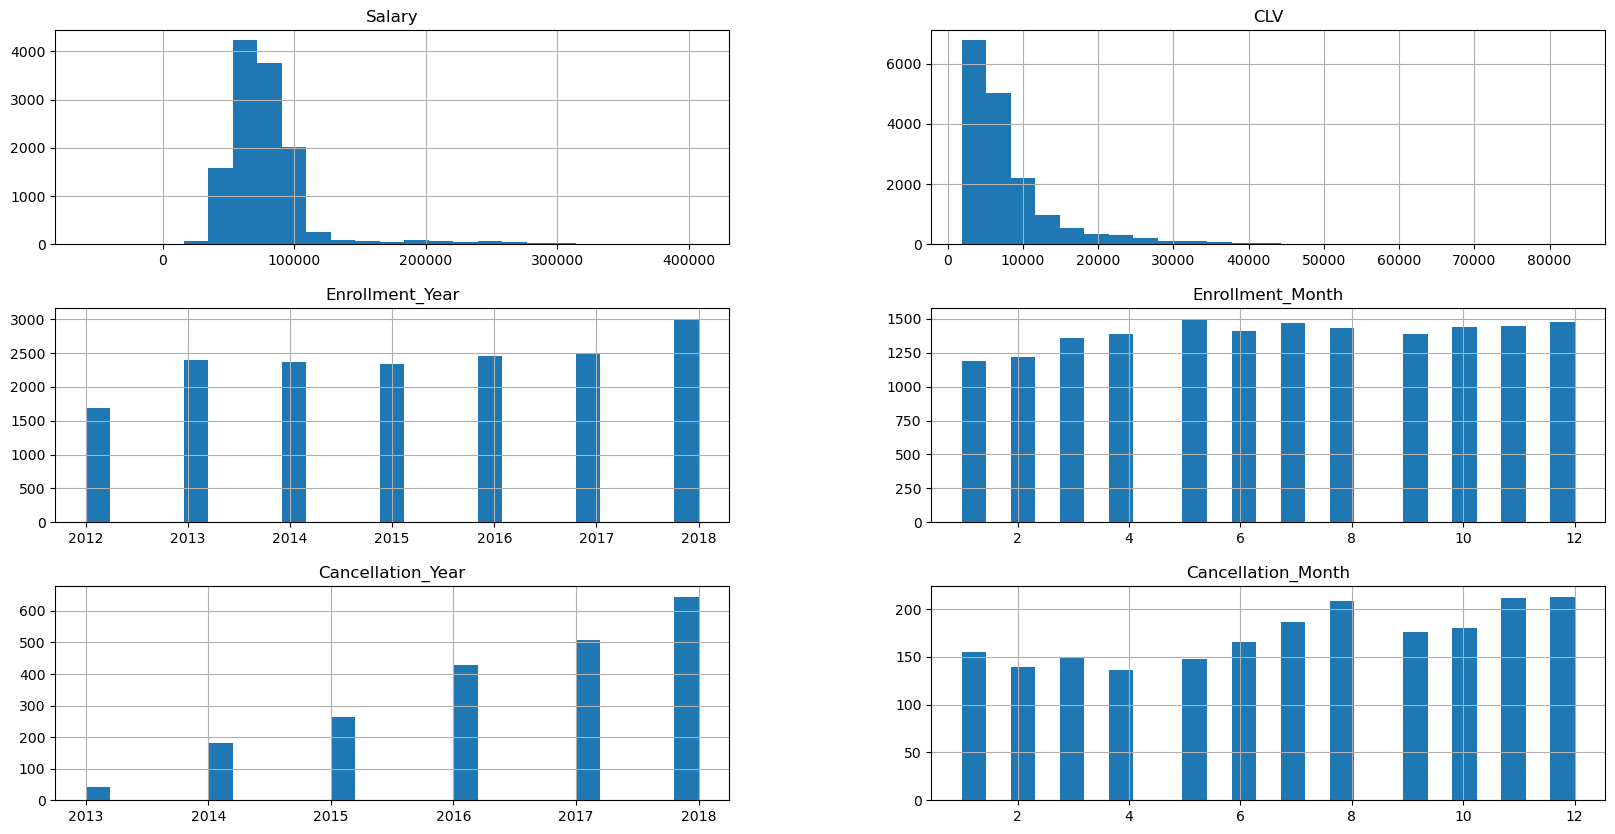

In [137]:
df_CLH[var_num[1:]].hist(bins=25, figsize=(20, 10));

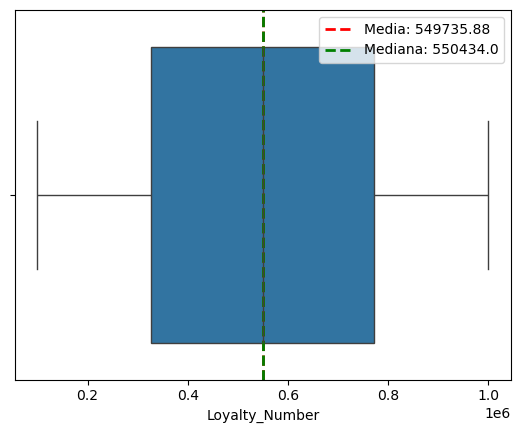

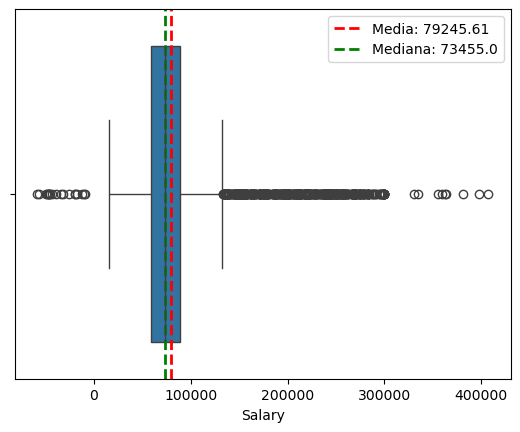

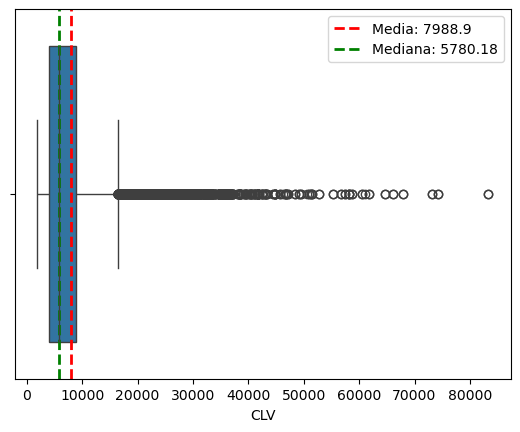

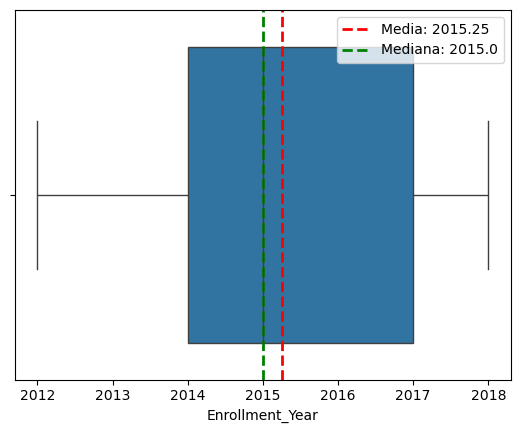

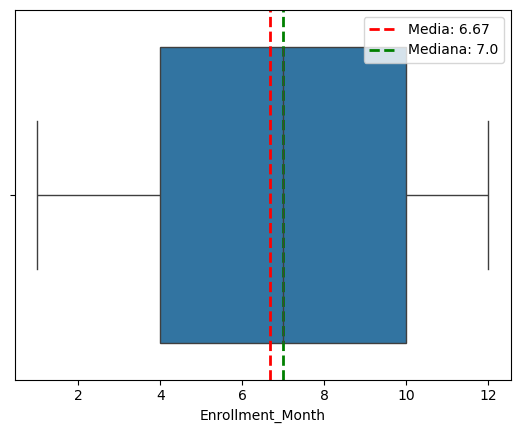

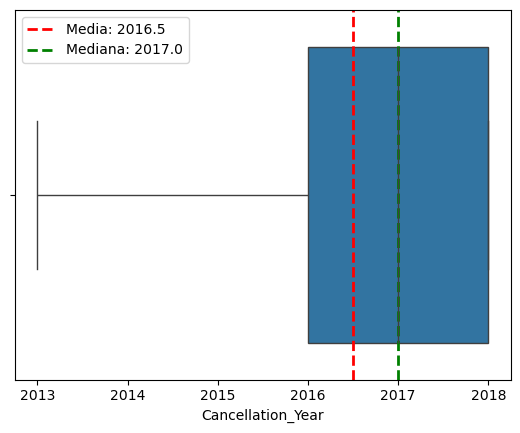

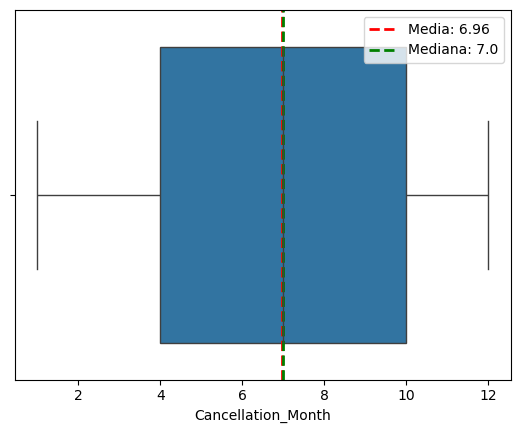

In [138]:
avn_boxplot(df_CLH, var_num)

In [139]:
# DUPLICADOS: 
func_duplicados(df_CLH)

Este dataframe no tiene duplicados.


In [140]:
# NULOS: 
var_nulos_df_CLH = variables_nulas(df_CLH)

,columna,%_nulos
7,Salary,25.321145
14,Cancellation_Year,87.650117
15,Cancellation_Month,87.650117


La siguiente columna tiene valores nulos: Salary
La siguiente columna tiene valores nulos: Cancellation_Year
La siguiente columna tiene valores nulos: Cancellation_Month


In [141]:
# Se tienen tres columnas con variables que tienen valores nulos, para saber como realizar la imputación, vamos a mirar su boxplots. 
# Una vez vistos sus boxplots decidimos imputar con su mediana

mediana_salary = df_CLH['Salary'].median()
mediana_cancellation_year = df_CLH['Cancellation_Year'].median()
mediana_cancellation_month = df_CLH['Cancellation_Month'].median()

df_CLH['Salary'] = df_CLH['Salary'].fillna(mediana_salary)
df_CLH['Cancellation_Year'] = df_CLH['Cancellation_Year'].fillna(mediana_cancellation_year)
df_CLH['Cancellation_Month'] = df_CLH['Cancellation_Month'].fillna(mediana_cancellation_month)

print(f'Valores nulos después de la imputación de Salary: {df_CLH['Salary'].isnull().sum()}')
print(f'Valores nulos después de la imputación de Cancellatior_Year: {df_CLH['Cancellation_Year'].isnull().sum()}')
print(f'Valores nulos después de la imputación de Cancellation_Month: {df_CLH['Cancellation_Month'].isnull().sum()}')

Valores nulos después de la imputación de Salary: 0
Valores nulos después de la imputación de Cancellatior_Year: 0
Valores nulos después de la imputación de Cancellation_Month: 0


In [143]:
# A continuación vamos a unir los dos dataframe: 

df_completo = df_CFA.merge(df_CLH, on = 'Loyalty_Number')
df_completo.head(2)

,Loyalty_Number,Year,Month,Flights_Booked,Flights_with_Companions,Total_Flights,Distance,Points_Accumulated,Points_Redeemed,Dollar_Cost_Points_Redeemed,Country,Province,City,Postal_Code,Gender,Education,Salary,Marital_Status,Loyalty_Card,CLV,Enrollment_Type,Enrollment_Year,Enrollment_Month,Cancellation_Year,Cancellation_Month
0,100018,2017,1,3,0,3,1521,152.0,0,0,Canada,Alberta,Edmonton,T9G_1W3,Female,Bachelor,92552.0,Married,Aurora,7919.20,Standard,2016,8,2017.0,7.0
1,100102,2017,1,10,4,14,2030,203.0,0,0,Canada,Ontario,Toronto,M1R_4K3,Male,College,73455.0,Single,Nova,2887.74,Standard,2013,3,2017.0,7.0


In [142]:
## UN BREVE RESULTADO DE LOS HISTOGRAMAS. 
## UN BREVE RESULTADO DE LOS BOXPLOTS.
## EXPLICAR MEJOR POR QUÉ IMPUTAMOS CON LA MEDIANA